In [1]:
# Paste this after you build selected_data_np, selected_label_np, and unknown_pair
import os
import joblib
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Try imports for XGBoost, LightGBM, Keras (TensorFlow)
try:
    import xgboost as xgb
    HAS_XGB = True
except Exception as e:
    HAS_XGB = False

try:
    import lightgbm as lgb
    HAS_LGB = True
except Exception as e:
    HAS_LGB = False

try:
    import tensorflow as tf
    from tensorflow import keras
    HAS_TF = True
except Exception as e:
    HAS_TF = False

OUTPUT_DIR = "results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def evaluate_cv(model_name, model_builder, X, y, scale_for_nn=False, epochs=30, batch_size=32):
    """
    model_builder: function that returns a (fit_fn, predict_proba_fn, save_fn) tuple or sklearn-like estimator.
    If it returns an sklearn-style estimator, we'll use fit/predict_proba directly.
    If model_name == 'DNN', model_builder should return a callable that builds a tf.keras model.
    """
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    mean_fpr = np.linspace(0, 1, 100)
    mean_recall = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    precisions = []
    scores = []
    roc_auc_scores = []
    y_true_all = []
    y_pred_all = []

    fold_idx = 0
    for train_idx, test_idx in skf.split(X, y):
        fold_idx += 1
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # scale only for models that need it (DNN, Logistic)
        if model_name == 'DNN' or scale_for_nn:
            scaler = StandardScaler(with_mean=False)
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        else:
            scaler = None

        # If model_builder returns an sklearn estimator:
        if hasattr(model_builder, '__call__') and model_name != 'DNN' and model_name not in ('xgboost', 'lightgbm_custom'):
            # model_builder returns an estimator instance
            model = model_builder()
            model.fit(X_train, y_train)
            proba = model.predict_proba(X_test)[:, 1]
            pred = model.predict(X_test)
            # optionally save the last model of CV
            joblib.dump(model, os.path.join(OUTPUT_DIR, f"{model_name}_fold{fold_idx}.joblib"))
        else:
            # Special handling: XGBoost, LightGBM custom or DNN
            if model_name == 'xgboost' and HAS_XGB:
                dtrain = xgb.DMatrix(X_train, label=y_train)
                dtest = xgb.DMatrix(X_test, label=y_test)
                params = {'objective':'binary:logistic', 'eval_metric':'auc', 'seed':42, 'verbosity':0}
                bst = xgb.train(params, dtrain, num_boost_round=100)
                proba = bst.predict(dtest)
                pred = (proba >= 0.5).astype(int)
                bst.save_model(os.path.join(OUTPUT_DIR, f"xgb_fold{fold_idx}.model"))
            elif model_name == 'lightgbm_custom' and HAS_LGB:
                lgb_train = lgb.Dataset(X_train, label=y_train)
                lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)
                params = {'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'seed': 42}
                gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=[lgb_eval], verbose_eval=False)
                proba = gbm.predict(X_test)
                pred = (proba >= 0.5).astype(int)
                gbm.save_model(os.path.join(OUTPUT_DIR, f"lgb_fold{fold_idx}.txt"))
            elif model_name == 'DNN' and HAS_TF:
                # build small dense model
                tf.keras.backend.clear_session()
                inp = X_train.shape[1]
                model = keras.Sequential([
                    keras.layers.Input(shape=(inp,)),
                    keras.layers.Dense(256, activation='relu'),
                    keras.layers.Dropout(0.3),
                    keras.layers.Dense(128, activation='relu'),
                    keras.layers.Dropout(0.2),
                    keras.layers.Dense(1, activation='sigmoid')
                ])
                model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
                model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.1)
                proba = model.predict(X_test).ravel()
                pred = (proba >= 0.5).astype(int)
                model.save(os.path.join(OUTPUT_DIR, f"dnn_fold{fold_idx}.h5"))
            else:
                raise RuntimeError(f"Unsupported model or missing package for {model_name}.")

        # metrics
        roc_auc = roc_auc_score(y_test, proba)
        roc_auc_scores.append(roc_auc)
        score = np.mean(pred == y_test)
        scores.append(score)

        fpr, tpr, _ = roc_curve(y_test, proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(auc(fpr, tpr))

        precision, recall, _ = precision_recall_curve(y_test, proba)
        precisions.append(np.interp(mean_recall, recall[::-1], precision[::-1]))

        y_true_all.extend(y_test.tolist())
        y_pred_all.extend(pred.tolist())

        print(f"[{model_name}] Fold {fold_idx} — ROC AUC: {roc_auc:.4f}, Accuracy: {score:.4f}")

    # finalize metrics and plotting
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    mean_precision = np.mean(precisions, axis=0)
    mean_auc_pr = auc(mean_recall, mean_precision)

    print(f"\n{model_name} Summary — Mean ROC AUC: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")
    print(f"{model_name} Summary — Mean AUPR: {mean_auc_pr:.4f}")

    # Plot ROC
    plt.figure(figsize=(7,5))
    plt.plot(mean_fpr, mean_tpr, lw=2, label=f"Mean ROC (AUC={mean_auc:.3f} ± {std_auc:.3f})")
    plt.plot([0,1], [0,1], linestyle='--', color='r')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title(f"ROC: {model_name}")
    plt.legend(); plt.show()

    # Plot PR
    plt.figure(figsize=(7,5))
    plt.plot(mean_recall, mean_precision, lw=2, label=f"Mean PR (AUPR={mean_auc_pr:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision-Recall: {model_name}")
    plt.legend(); plt.show()

    # final f1 computed on last fold's y_test/pred for quick check (you can compute global f1 too)
    f1 = f1_score(y_test, pred)
    print(f"{model_name} final fold F1: {f1:.4f}")

    return {
        'mean_roc_auc': float(np.mean(roc_auc_scores)),
        'mean_aupr': float(mean_auc_pr),
        'last_model_name': model_name
    }


# Model builders for sklearn-like interface
def build_random_forest():
    return RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1)

def build_logistic():
    return LogisticRegression(class_weight='balanced', max_iter=1000, solver='saga')

# Run experiments
results = {}
print("Training RandomForest...")
results['RandomForest'] = evaluate_cv('RandomForest', build_random_forest, selected_data_np, selected_label_np)

print("Training LogisticRegression...")
results['LogisticRegression'] = evaluate_cv('LogisticRegression', build_logistic, selected_data_np, selected_label_np, scale_for_nn=True)

if HAS_XGB:
    print("Training XGBoost...")
    results['XGBoost'] = evaluate_cv('xgboost', None, selected_data_np, selected_label_np)
else:
    print("XGBoost not installed; skipping.")

if HAS_LGB:
    print("Training LightGBM...")
    results['LightGBM'] = evaluate_cv('lightgbm_custom', None, selected_data_np, selected_label_np)
else:
    print("LightGBM not installed; skipping.")

if HAS_TF:
    print("Training DNN (Keras)...")
    results['DNN'] = evaluate_cv('DNN', None, selected_data_np, selected_label_np, scale_for_nn=True, epochs=40, batch_size=64)
else:
    print("TensorFlow not installed; skipping DNN.")

print("All training finished. Summary:")
for k,v in results.items():
    print(k, v)


Training RandomForest...


NameError: name 'selected_data_np' is not defined

In [ ]:
import random
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from numpy import interp
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score



In [ ]:
# Define input and output directories
input_data_dir = "data"
output_dir = "results"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Read CSV files using the input data directory path
disease_name = pd.read_csv(os.path.join(input_data_dir, 'disease_name.csv'),header=None)
snoRNA_name = pd.read_csv(os.path.join(input_data_dir, 'snoRNA_name.csv'),header=None)
SnoRNA_similarity = pd.read_csv(os.path.join(output_dir, 'IRS_matrix.csv'), header=None)
known_association = pd.read_csv(os.path.join(input_data_dir, 'known_snoRNA_disease.csv'), header=None)
disease_similarity = pd.read_csv(os.path.join(output_dir, 'IDS_matrix.csv'), header=None)



disease_semantic_similarity = np.zeros(disease_similarity.shape) 
snoRNA_functional_similarity = np.zeros(SnoRNA_similarity.shape) 
adjacency_matrix = np.zeros(known_association.shape) 




In [ ]:
disease_name.shape , snoRNA_name.shape , SnoRNA_similarity.shape , known_association.shape , disease_similarity.shape

((112, 2), (335, 1), (335, 335), (335, 112), (112, 112))

In [ ]:
disease_semantic_similarity = disease_similarity.values
snoRNA_functional_similarity = SnoRNA_similarity.values
adjacency_matrix = known_association.values

In [ ]:
# csv to array disease_semantic_similarity
for i in range(len(disease_name)):
    for j in range(len(disease_name)):
        disease_semantic_similarity[i, j] = disease_similarity.iloc[i, j]


# csv to array adjacency_matrix
for i in range(known_association.shape[0]):
    for j in range(known_association.shape[1]):
        adjacency_matrix[i, j] = known_association.iloc[i, j]

# csv to array snoRNA_functional_similarity
for i in range(len(snoRNA_name)):
    for j in range(len(snoRNA_name)):
        snoRNA_functional_similarity[i, j] = SnoRNA_similarity.iloc[i, j]



In [ ]:
print("Seperating the known and unknown associations..")
unknown = []
known = []
for x in range(known_association.shape[0]):
    for y in range(known_association.shape[1]):
        if adjacency_matrix[x, y] == 0:
            unknown.append((x, y))
        else:
            known.append((x, y))

major = []
for z in range(len(unknown)):
    a = disease_semantic_similarity[unknown[z][1], :].tolist()
    b = snoRNA_functional_similarity[unknown[z][0], :].tolist()
    q = a + b
    major.append(q) 

Seperating the known and unknown associations..


In [ ]:
np.array(major).shape

(36510, 447)

In [ ]:
len(a), len(b), len(q)

(112, 335, 447)

In [ ]:
## Run KMeans
# n_clusters = 23
# kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(major)
# labels = kmeans.labels_

# # Create dynamic lists for each cluster
# disease_rna_tup = [[] for _ in range(n_clusters)]

# # Efficient grouping using zip
# for (rna, dis), label in zip(unknown, labels):
#     disease_rna_tup[label].append((rna, dis))

# # Optional: sample proportionally
# sampled_disease_rna_tup = [
#     random.sample(cluster, max(1, int(len(cluster) / len(labels) * len(known))))
#     for cluster in disease_rna_tup
# ]

In [ ]:
print("Staring the clustering based sampling for unknown i.e. negative associations")
kmeans = KMeans(n_clusters=23, random_state=0).fit(major)
center = kmeans.cluster_centers_
labels = kmeans.labels_ # label is given to all the datapoints but within 1 to 20


# we have seperated x and y of each centre pair.
center_x = []
center_y = []
for j in range(len(center)):
    center_x.append(center[j][0])
    center_y.append(center[j][1])



Staring the clustering based sampling for unknown i.e. negative associations


In [ ]:
center.shape, len(center_x), len(center_y)

((23, 447), 23, 23)

In [ ]:
disease_rna_tup = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
for i in range(len(labels)):
    if labels[i] == 0:
        disease_rna_tup[0].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 1:
        disease_rna_tup[1].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 2:
        disease_rna_tup[2].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 3:
        disease_rna_tup[3].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 4:
        disease_rna_tup[4].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 5:
        disease_rna_tup[5].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 6:
        disease_rna_tup[6].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 7:
        disease_rna_tup[7].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 8:
        disease_rna_tup[8].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 9:
        disease_rna_tup[9].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 10:
        disease_rna_tup[10].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 11:
        disease_rna_tup[11].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 12:
        disease_rna_tup[12].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 13:
        disease_rna_tup[13].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 14:
        disease_rna_tup[14].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 15:
        disease_rna_tup[15].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 16:
        disease_rna_tup[16].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 17:
        disease_rna_tup[17].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 18:
        disease_rna_tup[18].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 19:
        disease_rna_tup[19].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 20:
        disease_rna_tup[20].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 21:
        disease_rna_tup[21].append((unknown[i][0], unknown[i][1]))
    elif labels[i] == 22:
        disease_rna_tup[22].append((unknown[i][0], unknown[i][1]))




In [ ]:
print("Final datasets are being prepared now..")
sampled_disease_rna_tup = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
for i in range(len(disease_rna_tup)):
    # print(int((len(disease_rna_tup[i])/len(labels)) * len(known)))
    sampled_disease_rna_tup[i] = random.sample(disease_rna_tup[i], int((len(disease_rna_tup[i])/len(labels)) * len(known)))

dataset = []
for rna in range(known_association.shape[0]):
    # print(f"rna val:{rna}")
    for disease in range(known_association.shape[1]):
        # print(f"disease val:{disease}")
        for i in range(len(sampled_disease_rna_tup)):
            if (rna, disease) in sampled_disease_rna_tup[i]:
                dataset.append((rna, disease))

for rna in range(known_association.shape[0]):
    for disease in range(known_association.shape[1]):
        if (rna, disease) in known:
            dataset.append((rna, disease))

length = len(dataset)



Final datasets are being prepared now..


In [ ]:
selected_x = []
selected_y = []
#now I am just taking only the similarities of disease and rna of sampled data.
for data in dataset:
    a = disease_semantic_similarity[data[1], :].tolist()
    b = snoRNA_functional_similarity[data[0], :].tolist()
    q = a + b
    selected_x.append(q)

    if (data[0], data[1]) in known:
        selected_y.append(1)
    else:
        selected_y.append(0)

selected_data_np = np.array(selected_x)
selected_label_np = np.array(selected_y)



In [ ]:
## Data prepation ends here before training the model--------------------------------

print("GBDTSVM classifier running...")
#### Gradient Boosting Classifier--------------------------------

GBDT=GradientBoostingClassifier(n_estimators = 12,max_depth=5,min_samples_leaf=3)
GBDT.fit(selected_data_np, selected_label_np)
OHE = OneHotEncoder()
OHE.fit(GBDT.apply(selected_data_np)[:, :, 0])

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

SVM = svm.SVC(kernel='rbf', probability=True)


GBDTSVM classifier running...


In [ ]:
# Create a pipeline that scales the data-snoRNA-disease and then applies SVM
pipeline = Pipeline([('scaler', StandardScaler(with_mean=False)), ('SVM', SVM)])
# Define the parameter grid for C and gamma
param_grid = {'SVM__C': [0.1, 1, 10, 100], 'SVM__gamma': [1, 0.1, 0.01, 0.001]}

# Use GridSearchCV to find the optimal parameters
grid = GridSearchCV(pipeline, param_grid, cv=5)

# # Train the classifier
# using 5 fold cross validation:

stratified_k_fold = StratifiedKFold(n_splits=5)
# Initialize lists to store predicted and actual values
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
precisions = []
recalls = []
roc_auc_scores = []
scores = []
mean_recall = np.linspace(0, 1, 100)
y_true = []
y_pred = []



In [ ]:
for train_index, test_index in stratified_k_fold.split(selected_data_np, selected_label_np):
    # Split the data into training and test sets
    X_train, X_test = selected_data_np[train_index], selected_data_np[test_index]
    y_train, y_test = selected_label_np[train_index], selected_label_np[test_index]

    grid.fit(OHE.transform(GBDT.apply(X_train)[:, :, 0]), y_train)   # Train the classifier

    predicted_probs = grid.predict_proba(OHE.transform(GBDT.apply(X_test)[:, :, 0]))[:, 1]  # Make predictions on the test set using the best parameters

    roc_auc = roc_auc_score(y_test, predicted_probs)  # Calculate the ROC AUC score and append it to the list
    print('ROC AUC:', roc_auc)
    roc_auc_scores.append(roc_auc)


    score = grid.score(OHE.transform(GBDT.apply(X_test)[:, :, 0]), y_test)  # Calculate the score and append it to the list
    print('Score:', score)
    scores.append(score)


    fpr, tpr, thresholds = roc_curve(y_test, predicted_probs)   # Compute ROC curve and area under the curve
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)


    precision, recall, _ = precision_recall_curve(y_test, predicted_probs)  # Compute Precision-Recall curve
    precisions.append(interp(mean_recall, recall[::-1], precision[::-1]))

    y_true.extend(y_test)
    predicted = grid.predict(OHE.transform(GBDT.apply(X_test)[:, :, 0]))
    y_pred.extend(predicted)





ROC AUC: 0.9734405940594059
Score: 0.8955223880597015
ROC AUC: 0.9857178217821783
Score: 0.9303482587064676
ROC AUC: 0.992759900990099
Score: 0.9527363184079602
ROC AUC: 0.9911509900990099
Score: 0.9577114427860697
ROC AUC: 0.9984825115677397
Score: 0.9750623441396509


In [ ]:
f1 = f1_score(y_test, predicted)
print("Final F1 Score:", f1)

Final F1 Score: 0.9748743718592965


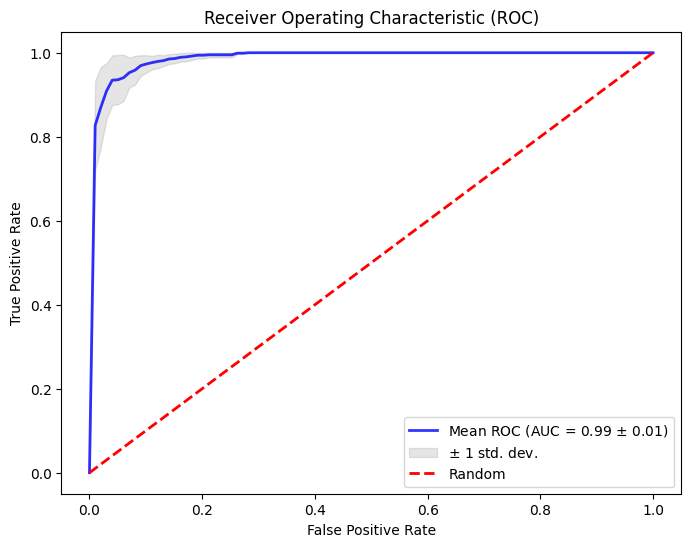

In [ ]:



# Plotting ROC curve
plt.figure(figsize=(8, 6))
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()




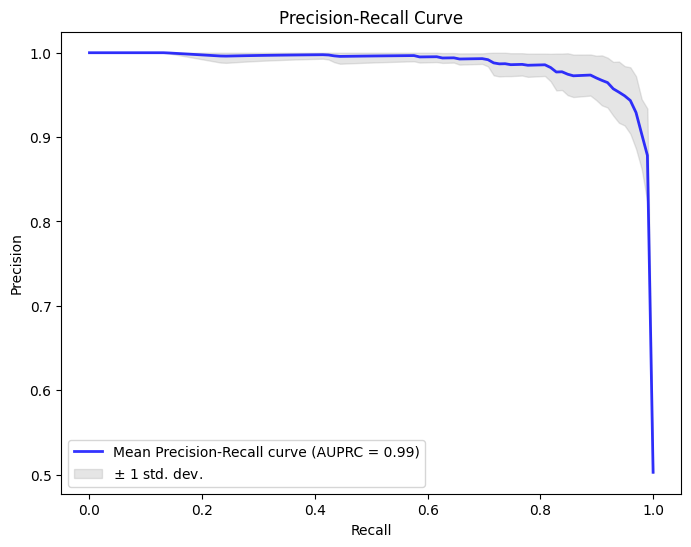

GBDTSVM Classifier training ends..
Predictions for unknown association now started


In [ ]:
# Plotting PRC curve
plt.figure(figsize=(8, 6))
mean_precision = np.mean(precisions, axis=0)
mean_precision[0] = 1.0
mean_auc_pr = auc(mean_recall, mean_precision)
plt.plot(mean_recall, mean_precision, color='b', label='Mean Precision-Recall curve (AUPRC = {:.2f})'.format(mean_auc_pr), lw=2, alpha=.8)
std_precision = np.std(precisions, axis=0)
precisions_upper = np.minimum(mean_precision + std_precision, 1)
precisions_lower = np.maximum(mean_precision - std_precision, 0)
plt.fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

print("GBDTSVM Classifier training ends..")
print("Predictions for unknown association now started")


In [ ]:
# Now predicting associations for all unknown pairs
unknown_pair = []

for data in unknown:
    a1 = disease_semantic_similarity[data[1], :].tolist()
    b1 = snoRNA_functional_similarity[data[0], :].tolist()
    q1 = a1 + b1
    unknown_pair.append(q1)



In [ ]:
#so far we have used certain number of samples from all the clustered unknown pairs, but now will predict for all the unknown pairs whether they have association or not
# here x1 contains the concatanated semantic similarity of diseases and functional similarity of snoRNAs of all unknown pairs

predicted_probabilities_all_unknowns = grid.predict_proba(OHE.transform(GBDT.apply(unknown_pair)[:, :, 0]))
unknown_pair_true_class = predicted_probabilities_all_unknowns[:, 1].tolist()

# here I have sorted the true class of all unknown pairs in descending order.
unknown_pair_true_class_np = np.array(unknown_pair_true_class)
sorted_probabilities = -np.sort(-unknown_pair_true_class_np, axis=None, kind='heapsort')


unknown_pair_true_class_matrix = np.matrix(unknown_pair_true_class)
sorted_class_index = np.argsort(-unknown_pair_true_class_matrix).tolist()
# print(len(sorted_class_index))
sorted_class_index = sorted_class_index[0]
# print(len(sorted_class_index))

# Write unknown true results to a text file
file_unknown_true_path = os.path.join(output_dir, "unknown_true_svm.txt")
with open(file_unknown_true_path, 'w') as file_unknown_true:
    file_unknown_true.writelines(['disease', '\t', 'SnoRNA', '\t', 'Score', '\n'])
    for i in range(len(sorted_class_index)):
        file_unknown_true.writelines([
            str(unknown[sorted_class_index[i]][1]), '\t',
            str(unknown[sorted_class_index[i]][0]), '\t',
            str(unknown_pair_true_class[sorted_class_index[i]]), '\n'
        ])



In [ ]:
# Convert unknown_true_svm.txt into a CSV file
file_unknown_true_csv_path = os.path.join(output_dir, "unknown_true_svm.csv")
df = pd.read_csv(file_unknown_true_path, delimiter='\t')
df.to_csv(file_unknown_true_csv_path, index=False)

# Create another CSV file where only rows with Score >= 0.75 are stored
file_unknown_true_75_csv_path = os.path.join(output_dir, "unknown_true_75_svm.csv")
df = pd.read_csv(file_unknown_true_csv_path)
df['Score'] = df['Score'].astype(float)
df = df[df['Score'] >= 0.75]
df.to_csv(file_unknown_true_75_csv_path, index=False)

print(f"Unknown association between the snoRNA-disease pairs are predicted and save in the output files successfully, saved in: {output_dir}")

Unknown association between the snoRNA-disease pairs are predicted and save in the output files successfully, saved in: results


: 